# 状態空間モデル(応用編)

## データロード

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PATH_DATA_INTERIM = Path("../data/interim/")
df_warranty_model_part_num_daily = pd.read_feather(PATH_DATA_INTERIM/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
selected_part_TD = ["27610-76G", "37950-58J", "95411-82K", 
                    "09283-350", "33920-77F", "33220-76G", "55311-75F",
                    "55311-72J", "53200-58J", "84702-70K"]

selected_part_S = ["46860-76G", "95200-58J", "37990-72J", "09262-350",
                   "17400-588"]

ts_dict = {}
ts_dict_monthly = {}
for part in selected_part_TD:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict[part] = ts_tmp
    ts_dict_monthly[part] = ts_tmp.resample("MS").sum()

In [6]:
df_term_devide = pd.DataFrame([{"part":"27610-76G", "valid_start":"2013-01-01", "test_start":"2014-01-01"},
                               {"part":"37950-58J", "valid_start":"2009-01-01", "test_start":"2010-01-01"},
                               {"part":"95411-82K", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"09283-350", "valid_start":"2000-01-01", "test_start":"2001-01-01"},
                               {"part":"33920-77F", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"33220-76G", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"55311-75F", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"55311-72J", "valid_start":"2011-01-01", "test_start":"2012-01-01"},
                               {"part":"53200-58J", "valid_start":"2008-01-01", "test_start":"2009-01-01"},
                               {"part":"84702-70K", "valid_start":"2016-01-01", "test_start":"2017-01-01"}])
df_term_devide.set_index("part", inplace=True)
df_term_devide["valid_start"] = pd.to_datetime(df_term_devide.valid_start)
df_term_devide["test_start"] = pd.to_datetime(df_term_devide.test_start)

In [7]:
from datetime import datetime, timedelta

ts_dict_monthly_train, ts_dict_monthly_valid, ts_dict_monthly_test = {},{},{}

for part in selected_part_TD:
    valid_start = df_term_devide.loc[part, "valid_start"]
    test_start = df_term_devide.loc[part, "test_start"]
    train_end = valid_start - timedelta(1)
    valid_end = test_start - timedelta(1)
    
    ts_dict_monthly_train[part] = ts_dict_monthly[part].loc[:train_end]
    ts_dict_monthly_valid[part] = ts_dict_monthly[part].loc[valid_start:valid_end]
    ts_dict_monthly_test[part] = ts_dict_monthly[part].loc[test_start:]

## ウォークフォワードバリデーション

前回では、データを訓練期間とバリデーション期間とテスト期間に分け、訓練期間でモデルのパラメータを推定し、バリデーション期間について予測を行い、その予測誤差を評価した。  

しかしながらこの場合、訓練期間とバリデーション期間をどのように取るかによって、予測誤差は異なるという問題が発生する。  
例えばトレンド転換点の直前までを訓練期間、トレンド転換の直後をバリデーション期間と取った場合、トレンド転換は一般に予測が難しいため、予測誤差が大きくなると予想される。  
他方、トレンド転換点後数ヶ月までを訓練期間、その後をバリデーション期間と取った場合は、既にトレンドが転換しているため、予測誤差は上記の場合に比べて小さくなると予想される。

ここではこうした「期間の取り方の違いによる予測誤差の変化」の影響を和らげるため、訓練期間+バリデーション期間の範囲内で、訓練期間とバリデーション期間の境目をずらしながら、モデルを訓練と評価を繰り返し行い、得られた予測誤差の集合からモデルを総合的に評価する。  
このような評価方法は**"ウォークフォワードバリデーション(Walk Forward Validation)"**と呼ばれる。この評価方法は時系列予測特有の方法である。

### ローカル線形トレンド&サイクルモデル

モデルは前回扱ったうちの一つ、ローカル線形トレンド&サイクルモデル。  
モデル式は以下のとおり。

$$y_{t} \sim N(\mu_{t} + c_{t}) \\
\mu_{t} \sim N(\mu_{t-1} + d_{t-1}, \sigma_{v}) \\ 
d_{t} \sim N(d_{t-1}, \sigma_{d}) \\
c_{t} \sim N(-\sum_{k=t-11}^{k=t-1}c_{k}, \sigma_{c}) \\
$$

ここで、$y_{t}$は観測値、$\mu_{t}$はレベル, $d_{t}$はトレンド, $c_{t}$は周期成分である。  

#### (発展)ローカル線形トレンド&サイクルモデルの行列表示

ちなみに、上のローカル線形トレンド&サイクルモデルは、状態方程式と観測方程式の形で、それぞれ以下のように書ける。

$$ {\bf x_{t}} = {\bf G_{t} x_{t-1}} + {\bf w_{t}},    {\bf w_{t}} \sim N(0, W_{t})$$

$$y_{t} = {\bf F_{t} x_{t}} + v_t, v_t \sim N(0,\sigma_{v})$$

ただし、
$${\bf x_t} = \left[\begin{array}{c}
            \mu_t \\
            d_t \\
            c_t \\
            c_{t-1} \\
            \vdots \\
            c_{t-11}
        \end{array}\right] \quad, 
  {\bf G_t} = \left[\begin{array}{cc|cccc}
            1 & 1 &  \\
            0 & 1 \\
            \hline
            && -1 & \dots & -1 & -1 \\
            && 1 \\
            &&& \ddots\\
            && && 1
        \end{array}\right] \quad,
  {\bf W_t} = \left[\begin{array}{cc|cccc}
            \sigma_v & 0 &  \\
            0 & \sigma_d \\
            \hline
            && \sigma_c &&& \\
            &&& 0 \\
            &&&& \ddots\\
            &&&&& 0
        \end{array}\right] \quad,
  {\bf F_t} = \left[\begin{array}{c|c}
            1,0 & 1,0, \dots, 0
        \end{array}\right] \quad    
        $$


#### 計算: そのまま

In [8]:
# trainとvalidを連結
ts = pd.concat([ts_dict_monthly_train["27610-76G"], ts_dict_monthly_valid["27610-76G"]])
ts = ts.resample("MS").mean()

In [7]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

def calc_mse_walkforward(ts=ts, lookback=12, forecast=12):
    mse_list = []
    time_list = []
    for i in range(lookback, ts.shape[0]-forecast):
        tmp_train = ts.iloc[i-lookback:i]
        tmp_valid = ts.iloc[i:i+forecast]
        m = UnobservedComponents(tmp_train, 'local linear trend', 
                                 freq_seasonal=[{"period":12}]).fit()
        pred = m.forecast(forecast)
        err = tmp_valid - pred
        mse = np.sqrt((err**2).mean())
        mse_list.append(mse)
        time_list.append(tmp_train.index[-1])
    s_mse = pd.Series(mse_list, index=time_list)
    return s_mse

# 1年学習->1年予測で評価
s_mse_1y = calc_mse_walkforward(ts=ts, lookback=12, forecast=12)

/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [8]:
# 3年学習->1年予測で評価
s_mse_3y = calc_mse_walkforward(ts=ts, lookback=12*3, forecast=12)

# 5年学習->1年予測で評価
s_mse_5y = calc_mse_walkforward(ts=ts, lookback=12*5, forecast=12)

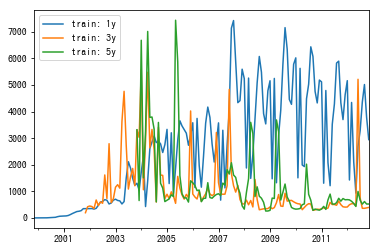

In [10]:
s_mse_1y.plot(label="train: 1y")
s_mse_3y.plot(label="train: 3y")
s_mse_5y.plot(label="train: 5y")
plt.legend()

1年は明らかに良くないが、3年と5年はそれほど変わらない。

#### 計算: 対数変換

In [11]:
def calc_mse_walkforward_log(ts=ts, lookback=12, forecast=12):
    mse_list = []
    time_list = []
    for i in range(lookback, ts.shape[0]-forecast):
        tmp_train = ts.iloc[i-lookback:i]
        tmp_valid = ts.iloc[i:i+forecast]
        tmp_train = np.log1p(tmp_train) # 1を足してから、自然対数を取る関数。1を足すので、0があってもエラーにならない
        m = UnobservedComponents(tmp_train, 'local linear trend', 
                                 freq_seasonal=[{"period":12}]).fit()
        pred = m.forecast(forecast)
        pred = np.expm1(pred) # expを取ってから、1を引く関数。log1pをもとに戻すことができる(log1pの逆関数)
        err = tmp_valid - pred
        mse = np.sqrt((err**2).mean())
        mse_list.append(mse)
        time_list.append(tmp_train.index[-1])
    s_mse = pd.Series(mse_list, index=time_list)
    return s_mse

In [12]:
# 1年学習->1年予測で評価
s_mse_1y_log = calc_mse_walkforward_log(ts=ts, lookback=12, forecast=12)

# 3年学習->1年予測で評価
s_mse_3y_log = calc_mse_walkforward_log(ts=ts, lookback=12*3, forecast=12)

# 5年学習->1年予測で評価
s_mse_5y_log = calc_mse_walkforward_log(ts=ts, lookback=12*5, forecast=12)

/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning

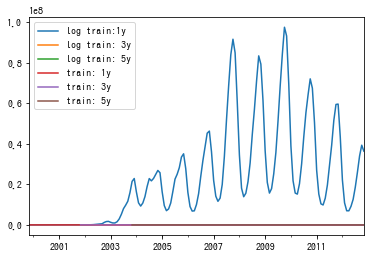

In [13]:
s_mse_1y_log.plot(label="log train:1y")
s_mse_3y_log.plot(label="log train: 3y")
s_mse_5y_log.plot(label="log train: 5y")
s_mse_1y.plot(label="train: 1y")
s_mse_3y.plot(label="train: 3y")
s_mse_5y.plot(label="train: 5y")
plt.legend()

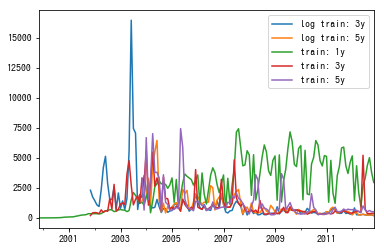

In [14]:
# s_mse_1y_log.plot(label="log train:1y")
s_mse_3y_log.plot(label="log train: 3y")
s_mse_5y_log.plot(label="log train: 5y")
s_mse_1y.plot(label="train: 1y")
s_mse_3y.plot(label="train: 3y")
s_mse_5y.plot(label="train: 5y")
plt.legend()

対数変換を取って5年のパフォーマンスが良い

In [15]:
print("対数変換,1年:", s_mse_1y_log.mean())
print("対数変換,3年:", s_mse_3y_log.mean())
print("対数変換,5年:", s_mse_5y_log.mean())
print("変換なし,1年:", s_mse_1y.mean())
print("変換なし,3年:", s_mse_3y.mean())
print("変換なし,5年:", s_mse_5y.mean())

対数変換,1年: 23324950.461518906
対数変換,3年: 1147.3946620987144
対数変換,5年: 1029.310590360332
変換なし,1年: 2590.178134693079
変換なし,3年: 1097.447918249401
変換なし,5年: 1271.625650493974
